# My first notebook

In this Jupyter Notebook an example of seasonal forecast anomaly will be presented. The following Python (3.10) libraries were used:
cfgrib, , xarray, matplotlib, and cartopy. The notebook is divided in 4 sections:
1. retrieve the desired data,
2. calculate the reference climate mean,
3. calculate seasonal forecast anomalies,
4. plot a spatial map.

In [ ]:
import cdsapi
import urllib3 
urllib3.disable_warnings()

import cfgrib
import numpy as np
import xarray as xr
import pandas as pd
from dateutil.relativedelta import relativedelta
import datetime

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from IPython.display import Image

## Retrieve the desired data
Before the first use of the Climate Data Store, the CDS API personal access token was set up by following the instructions [CDS API](https://cds.climate.copernicus.eu/how-to-api). Additionally, the [Terms of use](https://cds.climate.copernicus.eu/datasets) were accepted. In this example the Seasonal forecast monthly statistics on single levels data from ECMWF, for system 5 and variable 2m temperature, were analysed. For the reference period, years from 1981 to 2010 (for May) and forecast from year 2022 were taken. The leadtime months were from May until October. The geographical area of interest was Mediterranean.

In [ ]:
DATADIR = './'

# Download CDS data
c = cdsapi.Client()
c.retrieve("seasonal-monthly-single-levels",
        {"originating_centre": "ecmwf",
        "system": "5",
        "variable": ["2m_temperature"],
        "year": [
            "1981", "1982", "1983",
            "1984", "1985", "1986",
            "1987", "1988", "1989",
            "1990", "1991", "1992",
            "1993", "1994", "1995",
            "1996", "1997", "1998",
            "1999", "2000", "2001",
            "2002", "2003", "2004",
            "2005", "2006", "2007",
            "2008", "2009", "2010"
        ],
        "month": ["05"],
        "leadtime_month": [
            "1",
            "2",
            "3",
            "4",
            "5",
            "6"
        ],
        "data_format": "grib",
        "product_type": ["monthly_mean"],
        "area": [50, -10, 30, 40]
        },
str(DATADIR) + '/ecmwf_seas5_1981-2010_05_hindcast_monthly_t2m_Mediterranean.grib')

c.retrieve("seasonal-monthly-single-levels",
        {"originating_centre": "ecmwf",
        "system": "5",
        "variable": ["2m_temperature"],
        "year": ["2022"],
        "month": ["05"],
        "leadtime_month": [
            "1",
            "2",
            "3",
            "4",
            "5",
            "6"
        ],
        "data_format": "grib",
        "product_type": ["monthly_mean"],
        "area": [50, -10, 30, 40]
        },
str(DATADIR) + '/ecmwf_seas5_2022_05_forecast_monthly_t2m_Mediterranean.grib')

## Calculate the reference climate mean

In [ ]:
ds_hindcast = xr.open_dataset(str(DATADIR) + '/ecmwf_seas5_1981-2010_05_hindcast_monthly_t2m_Mediterranean.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
# Variable 2m temperature
t2m_hindcast = ds_hindcast['t2m']
# Average over ensemble members and time
t2m_hindcast_mean = t2m_hindcast.mean(['number', 'time'])

## Calculate seasonal forecast anomalies

In [ ]:
ds_forecast = xr.open_dataset(str(DATADIR) + '/ecmwf_seas5_2022_05_forecast_monthly_t2m_Mediterranean.grib', engine='cfgrib', 
                                 backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
# Computing the mean over ensemble members
ds_forecast_mean = ds_forecast.mean('number')
# Calculate seasonal forecast anomalies
seas5_anomalies = ds_forecast_mean['t2m'] - t2m_hindcast_mean
# Calculate timestamp
valid_time = [pd.to_datetime(seas5_anomalies.time.values) +
              relativedelta(months=fcmonth-1) for fcmonth in seas5_anomalies.forecastMonth]
seas5_anomalies = seas5_anomalies.assign_coords(valid_time=('forecastMonth',valid_time))

## Plot a spatial map

In [ ]:
# Visualise seasonal forecast anomalies
seas5_anomalies_Mediterranean = seas5_anomalies.assign_coords(longitude=(((seas5_anomalies.longitude + 180) % 360)
                                                  - 180)).sortby('longitude')
# Select a leadtime to visualise
lead_time = 3

# Define figure
fig, ax = plt.subplots(1, 1, figsize = (10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

new_date_format = seas5_anomalies_Mediterranean['valid_time'].dt.strftime('%m.%Y')
sub = (47, -10, 30, 37) # North/West/South/East

# Define a title
ax.set_title('ECMWF SEAS5 temperature 2m anomaly\n averaged over 51 ensemble members\n' +
             '(with respect to the 1981 - 2010 reference period)\n Start: ' +
             str(new_date_format[0].data) + 
             ' -> Valid date: ' + str(new_date_format[lead_time-1].data) + '\n',
             fontsize=18)
# Plot data
im = ax.pcolormesh(seas5_anomalies_Mediterranean.longitude.values,
                   seas5_anomalies_Mediterranean.latitude.values,
                   seas5_anomalies_Mediterranean[lead_time-1,:,:],
                   cmap='bwr', vmin=-5, vmax=5)
ax.coastlines(color='black')
# Set (x0, x1, y0, y1) of the map in the coordinate system
ax.set_extent([sub[1],sub[3],sub[2],sub[0]], crs=ccrs.PlateCarree())

# Create a colour bar at the bottom of the fugure
fig.subplots_adjust(bottom=0.0)
# Add axis to make space for colour bar (left, bottom, width, height)
cbar_ax = fig.add_axes([0.3, 0.1, 0.5, 0.02])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Temperature 2m anomaly (° C)')

In [ ]:
# Save the figure
fig.savefig(str(DATADIR) + '/AvgT2mAnomalyForecastMediterranean.png')

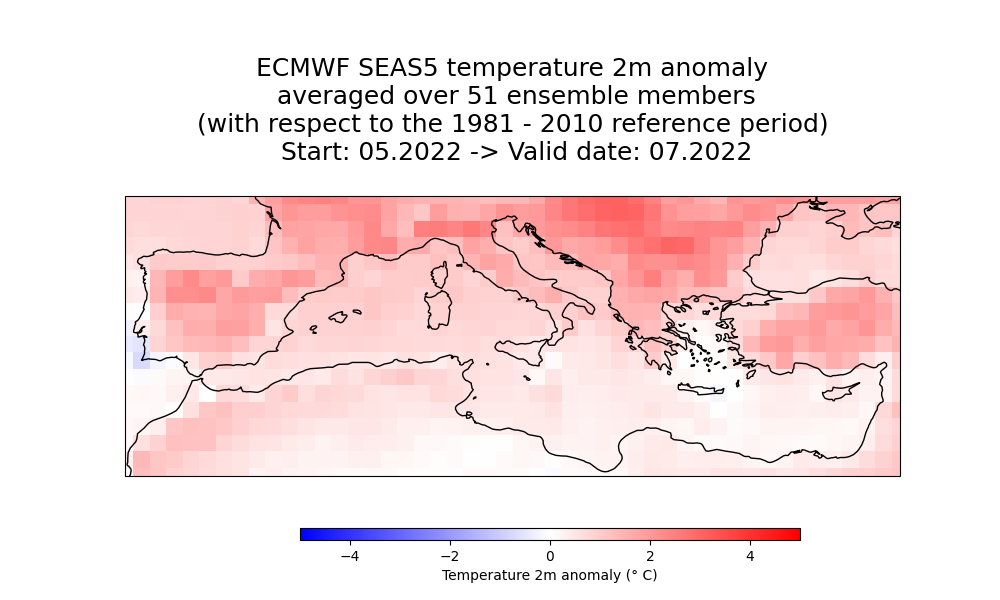

In [5]:
Image("AvgT2mAnomalyForecastMediterranean.png")

In the above figure one can see that the temperature 2m anomaly is negative along a small area of the Portuguese coast. Otherwise it is positive or close to zero.